In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-38-a8aed9fadacf>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# a function that creates data

def createSomeData(nPerClust):

  A = [1, 1]
  B = [5, 1]
  C = [4, 4]

  # generate data
  a = [ A[0] + np.random.randn(nPerClust), A[1] + np.random.randn(nPerClust)]
  b = [ B[0] + np.random.randn(nPerClust), B[1] + np.random.randn(nPerClust)]
  c = [ C[0] + np.random.randn(nPerClust), C[1] + np.random.randn(nPerClust)]


  # true labels =
  labels_np = np.hstack((np.zeros((nPerClust)),
                np.ones((nPerClust)),
                1 + np.ones((nPerClust))))

  data = np.hstack((a, b, c)).T

  # putting all outputs into a dictionary

  output = {}
  output['data'] = torch.tensor(data).float()
  output['labels'] = torch.tensor(labels_np).long()

  # splitting the data
  train_data, test_data, train_labels, test_labels = train_test_split(output['data'], output['labels'], test_size = .2)

  train_data = TensorDataset(train_data, train_labels)
  test_data = TensorDataset(test_data, test_labels)

  # finally translate into dataloader objects
  batchsize = 8
  output['train_data'] = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
  output['test_data'] = DataLoader(test_data, batch_size = len(test_data))

  return output

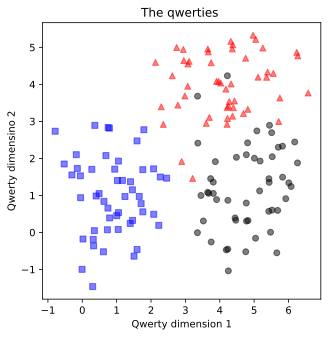

In [ ]:
# checking the function

theData = createSomeData(50)

data = theData['data']
labels = theData['labels']

# show the data
fig = plt.figure(figsize = (5,5))
plt.plot(data[np.where(labels == 0), 0], data[np.where(labels == 0), 1], 'bs', alpha = .5)
plt.plot(data[np.where(labels == 1), 0], data[np.where(labels == 1), 1], 'ko', alpha = .5)
plt.plot(data[np.where(labels == 2), 0], data[np.where(labels == 2), 1], 'r^', alpha = .5)
plt.title('The qwerties ')
plt.xlabel('Qwerty dimension 1')
plt.ylabel('Qwerty dimensino 2')
plt.show()


In [ ]:
def createTheqwertyNet(hidden_layers, units):

    class qwertyNet(nn.Module):
        def __init__(self, hidden_layers, units):
            super().__init__()


            self.layers = nn.ModuleDict()

            # input layer
            self.layers['input'] = nn.Linear(2, units)
            self.hidden_layers = hidden_layers

            ### hidden layers
            for i in range(self.hidden_layers):
                self.layers[f'hidden{i}'] = nn.Linear(units,units)

            # output layer
            self.layers['output'] = nn.Linear(units, 10)

        def forward(self, X):

            X = F.relu(self.layers['input'](X))
            for i in range(self.hidden_layers):
                X = F.relu(self.layers[f'hidden{i}'](X))



            return self.layers['output'](X)

    # create the model instance
    net = qwertyNet(hidden_layers, units)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer

In [ ]:
def function2trainTheModel(hidden_layers, units):

    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheqwertyNet(hidden_layers, units)

    # losses
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []


    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_data:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # matches
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)

        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        net.eval()
        X, y = next(iter(test_data))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net

In [ ]:
# testing the model
# generate the data
theData = createSomeData(200)
train_data = theData['train_data']
test_data = theData['test_data']

# run the model
trainAcc, testAcc, losses, net = function2trainTheModel(1, 80)

Text(0, 0.5, 'Accuracy (%)')

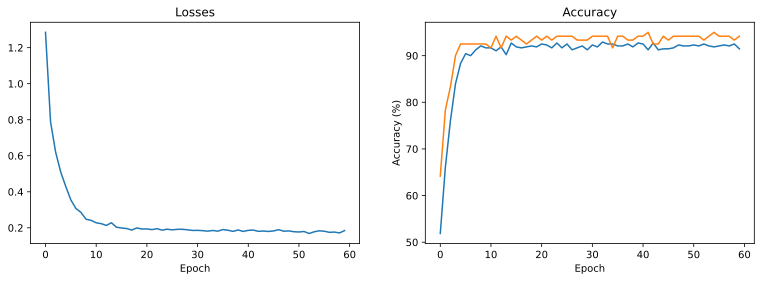

In [ ]:
fig, ax = plt.subplots(1,2 , figsize = (13,4))

ax[0].plot(losses)
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')


ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')

In [ ]:
# parameters for the model
nNodesInModel = 80
layersRange = [1, 5, 10, 20]
nDatapoints = np.arange(50, 551, 50)

# create a legend for later plotting
legend = []

# print out the model architechtures
for lidx, layers in enumerate(layersRange):

    # create a model
    unitsperlayer = int(nNodesInModel/layersRange[lidx])
    net = createTheqwertyNet(layers, unitsperlayer)[0]

    # count its parameters
    nparams = np.sum([p.numel() for p in net.parameters() if p.requires_grad])
    legend.append("%s layers, %s units, %s params" %(layers, unitsperlayer, nparams))
    print('This model will have %s layers, each with %s units, totalling %s parameters '%(layers, unitsperlayer, nparams))




This model will have 1 layers, each with 80 units, totalling 7530 parameters 
This model will have 5 layers, each with 16 units, totalling 1578 parameters 
This model will have 10 layers, each with 8 units, totalling 834 parameters 
This model will have 20 layers, each with 4 units, totalling 462 parameters 


In [ ]:


# initialize results matrix
results = np.zeros((len(nDatapoints),len(layersRange),2))

for didx,pnts in enumerate(nDatapoints):

  # create data (note: same data for each layer manipulation!)
  theData = createSomeData(pnts)
  train_data = theData['train_data']
  test_data  = theData['test_data']


  # now loop over layers
  for lidx,layers in enumerate(layersRange):

    unitsperlayer = int(nNodesInModel/layersRange[lidx])
    trainAcc,testAcc,losses,net = function2trainTheModel(unitsperlayer,layers)

    # average of last 5 accuracies and losses
    results[didx,lidx,0] = np.mean( testAcc[-5:] )
    results[didx,lidx,1] = np.mean(losses[-5:]).item()

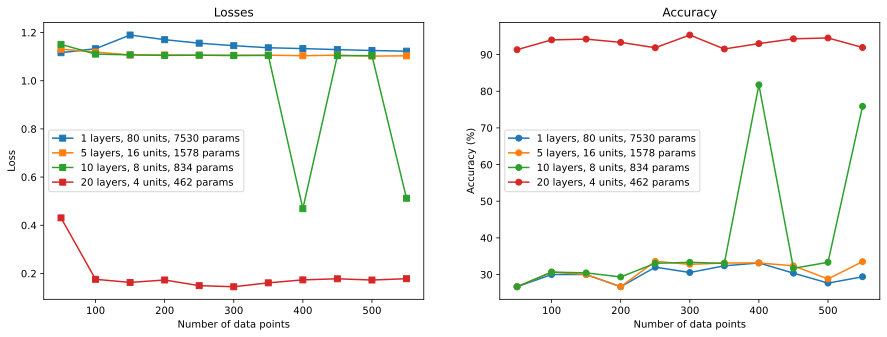

In [ ]:
# results!

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(nDatapoints,results[:,:,1],'s-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(nDatapoints,results[:,:,0],'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)
plt.show()
